In [1]:
import pandas as pd
import os
import sys
import requests

#sys.path.append(os.path.abspath("../../src"))
from vayu_gnn.dbx.dbx_config import dbx_helper, DropboxHelper


### Get static and dynamic sensor data from Patna and Gurugram

In [3]:
import requests
import pandas as pd
from io import StringIO

def fetch_sensor_data():
    # API endpoint and headers
    url = "https://vayuapi.undp.org.in/device/api/v1/sensor-data-download"
    headers = {
        "accept": "application/json",
        "Content-Type": "application/json"
    }
    
    # Define the period: from June 2024 through February 2025
    months_years = [
        ("June", "2024"),
        ("July", "2024"),
        ("August", "2024"),
        ("September", "2024"),
        ("October", "2024"),
        ("November", "2024"),
        ("December", "2024"),
        ("January", "2025"),
        ("February", "2025")
    ]
    
    # Define the cities and device types
    cities = ["Gurugram"]
    device_types = ["static"]

    # Loop through each city and device type
    for city in cities:
        for device_type in device_types:
            monthly_dfs = []  
            if city == "Gurugram":
                months_years.pop(0)
            for month, year in months_years:
                print(f"Fetching data for {city}, {device_type} for {month} {year}")
                
                # Prepare payload for the API call
                payload = {
                    "month": month,
                    "year": year,
                    "city": city,
                    "device_type": device_type
                }
                response = requests.post(url, headers=headers, json=payload)
                
                if response.status_code == 200:
                    data = response.json()
                    if data.get("success"):
                        download_link = data.get("data")
                        csv_response = requests.get(download_link)
                        if csv_response.status_code == 200:
                            # Convert the CSV content to a dataframe
                            csv_content = csv_response.content.decode('utf-8')
                            df = pd.read_csv(StringIO(csv_content))
                            monthly_dfs.append(df)
                        else:
                            print(f"Failed to download CSV for {city}, {device_type} for {month} {year}. Status code: {csv_response.status_code}")
                    else:
                        print(f"API error for {city}, {device_type} for {month} {year}: {data.get('message')}")
                else:
                    print(f"HTTP error for {city}, {device_type} for {month} {year}: {response.status_code}")
            
            # Concatenate all the monthly dataframes if any data was retrieved
            if monthly_dfs:
                concatenated_df = pd.concat(monthly_dfs, ignore_index=True)
            else:
                concatenated_df = pd.DataFrame()  # Empty dataframe if no data
            
            dbx_helper.write_parquet(concatenated_df, dbx_helper.raw_input_path, f'sensor_data/{city}',  f"{device_type}_sensor_data.parquet")

    return None

# Execute the function to get the four dataframes
dataframes = fetch_sensor_data()

Fetching data for Gurugram, static for July 2024
Fetching data for Gurugram, static for August 2024


KeyboardInterrupt: 

In [4]:
df = dataframes['Gurugram_static']

In [5]:
print(60*24*60)

86400


In [7]:
# fix mixed types
del patna_static, dataframes

In [ ]:
# Write raw df to dropbox

In [11]:
df_patna_static   = dataframes.get("Patna_static")
print("Patna static:", df_patna_static.shape)

Patna static: (7023094, 13)


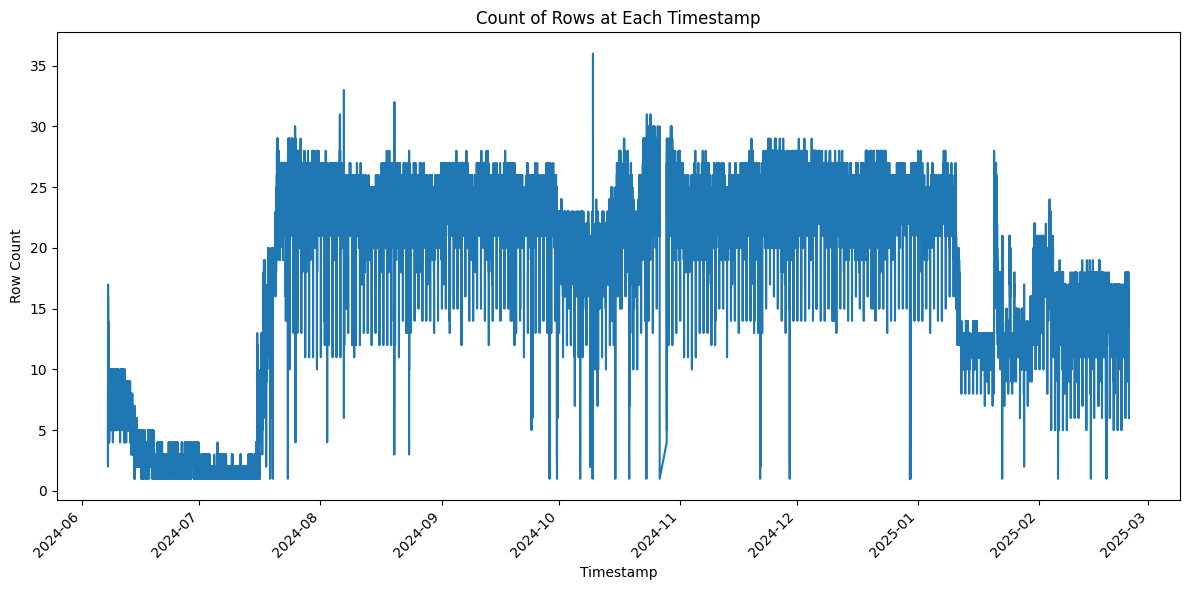

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame
# Convert the 'data_created_time' column to datetime

df = df_patna_static
df['data_created_time'] = pd.to_datetime(df['data_created_time'])

# Group by the timestamp and count the number of rows for each timestamp
timestamp_counts = df.groupby('data_created_time').size()

# Plot the results
plt.figure(figsize=(12, 6))
timestamp_counts.plot(kind='line')  # You could also try 'bar' if preferred
plt.xlabel("Timestamp")
plt.ylabel("Row Count")
plt.title("Count of Rows at Each Timestamp")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
import requests

# API endpoint
url = "https://vayuapi.undp.org.in/device/api/v1/sensor-data-download"

# Headers
headers = {
    "accept": "application/json",
    "Content-Type": "application/json"
}

# Request payload
payload = {
    "month": "September",
    "year": "2024",
    "city": "Patna",
    "device_type": "dynamic"
}

# Send POST request
response = requests.post(url, headers=headers, json=payload)

# Check the response
if response.status_code == 200:
    data = response.json()
    if data["success"]:
        download_link = data["data"]
        print(f"Data download link: {download_link}")
        
        # Download the CSV file
        csv_response = requests.get(download_link)
        if csv_response.status_code == 200:
            # Save the file with a dynamic name
            file_name = f"vayu_{payload['city']}_{payload['device_type']}_sensor_data_{payload['month']}_{payload['year']}.csv"
            with open(file_name, 'wb') as file:
                file.write(csv_response.content)
            print(f"File downloaded successfully: {file_name}")
        else:
            print(f"Failed to download CSV file from the link. Status code: {csv_response.status_code}")
    else:
        print(f"Failed to download data: {data['message']}")
else:
    print(f"Error: {response.status_code} - {response.text}")

Data download link: https://undpin176st003.blob.core.windows.net/data/Downloads/Patna/sensor-data/data-dynamic-sensor/vayu_Patna_dynamic_sensor_data_September_2024.csv
File downloaded successfully: vayu_Patna_dynamic_sensor_data_September_2024.csv


In [7]:
csv_response

<Response [200]>